# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, confusion_matrix, ConfusionMatrixDisplay

# Question 1: Exploratory Data Analysis

In [1994]:
# Loading the data
data = pd.read_csv("data\\Loan Status Prediction.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [1995]:
data["Dependents"].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

In [1996]:
# Overview of the data structure
print(f"Shape: {data.shape}")
print("\nData Information")
print(data.info())

Shape: (614, 13)

Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None


In [1997]:
# Data summary statistics
# Get per column statistics for numerical columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


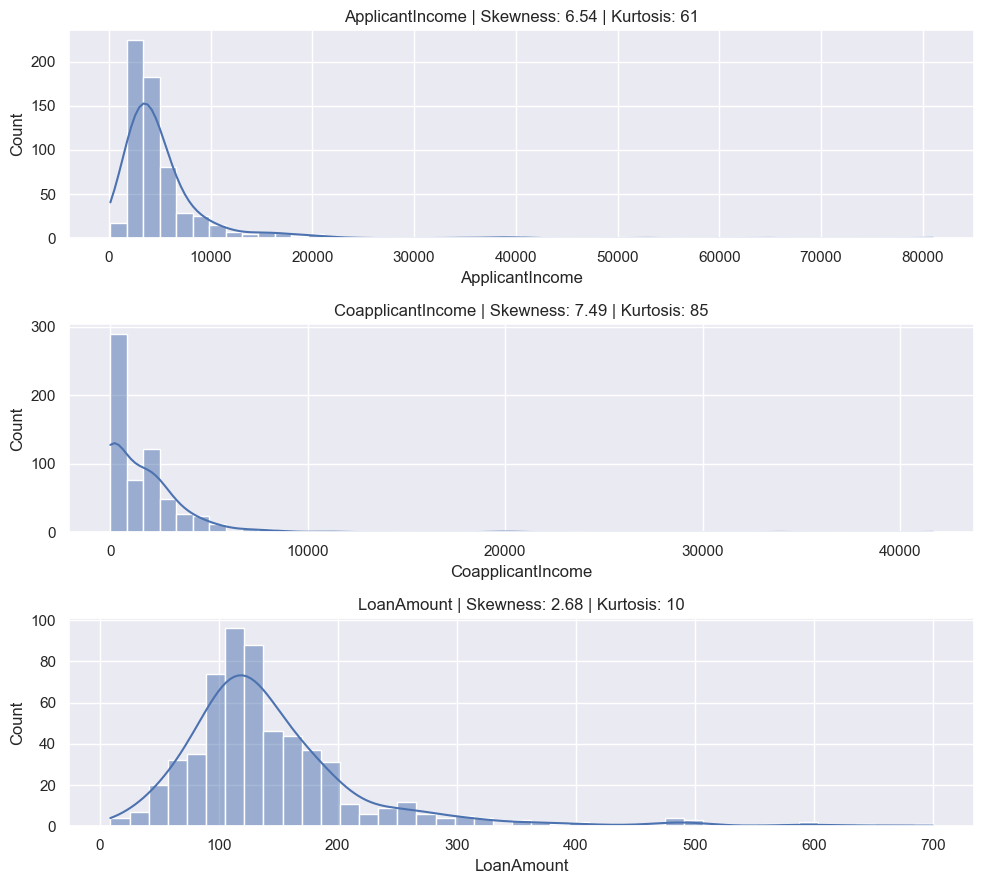

In [1998]:
# Calculating skewness and kurtosis for numerical columns
sns.set_style("darkgrid")
numerical_columns = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]
plt.figure(figsize=(10, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, idx)
    sns.histplot(data[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(data[feature].skew(), 2)} | Kurtosis: {round(data[feature].kurtosis())}")
plt.tight_layout()
plt.show()

# Question 2: Data Cleaning

In [1999]:
# Counting missing values in each feature, as a % of total dataset length
np.round(data.isnull().mean() * 100, 3)

Loan_ID              0.000
Gender               2.117
Married              0.489
Dependents           2.443
Education            0.000
Self_Employed        5.212
ApplicantIncome      0.000
CoapplicantIncome    0.000
LoanAmount           3.583
Loan_Amount_Term     2.280
Credit_History       8.143
Property_Area        0.000
Loan_Status          0.000
dtype: float64

In [2000]:
# Dealing with missing values by imputation
# This means using estimates and calculated values to fill in the missing values
# For the numerical features such as Loan Amount, we will use median for imputation
data["LoanAmount"] = data["LoanAmount"].fillna(data["LoanAmount"].median())
data["Loan_Amount_Term"] = data["Loan_Amount_Term"].fillna(data["Loan_Amount_Term"].median())
# For categorical data with missing values, we will use mode for imputation
categorical_columns = ["Gender", "Married", "Dependents", "Education",
                       "Self_Employed", "Credit_History", "Property_Area"]
for column in categorical_columns:
    data[column] = data[column].fillna(data[column].mode()[0])

In [2001]:
# Counting missing values in each feature, as a % of total dataset length
np.round(data.isna().mean() * 100, 3)
# We can see that all missing values have been dealt with

Loan_ID              0.0
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64

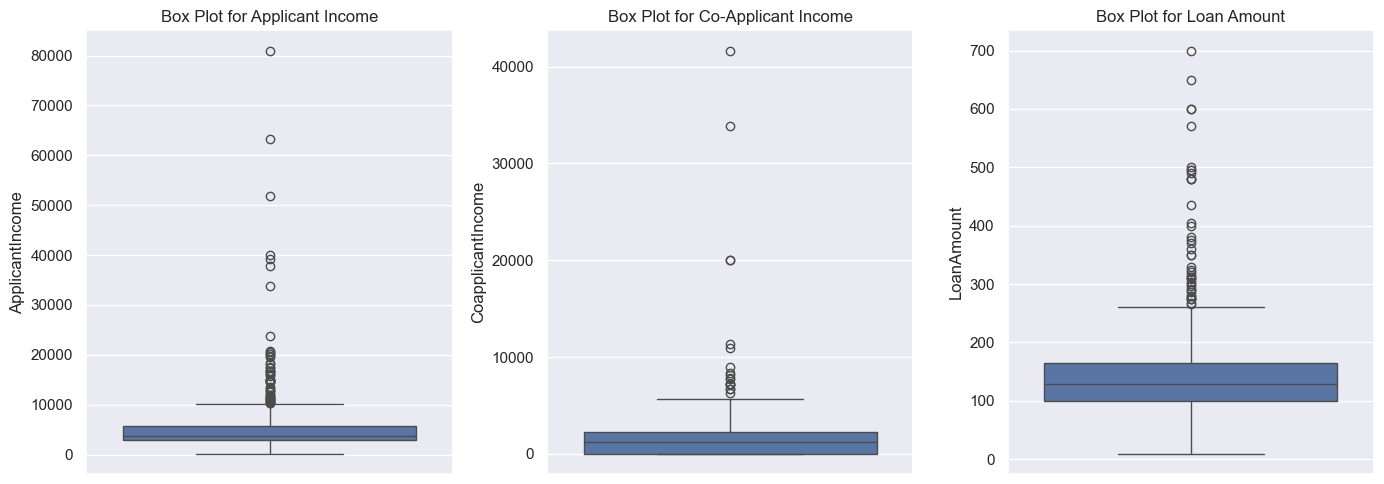

In [2002]:
# The data distribution before dealing with outliers - Box Plots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
# Starting with applicant income
sns.boxplot(data["ApplicantIncome"], ax=axes[0])
axes[0].set_title("Box Plot for Applicant Income")
# For coapplicant income
sns.boxplot(data["CoapplicantIncome"], ax=axes[1])
axes[1].set_title("Box Plot for Co-Applicant Income")
# For coapplicant income
sns.boxplot(data["LoanAmount"], ax=axes[2])
axes[2].set_title("Box Plot for Loan Amount")
plt.tight_layout()
plt.show()


In [2003]:
# Outlier detection using IQR since the data is mostly skewed
# Also, not all the features follow a normal distribution
# To detect outliers using IQR, find the lower and upper bounds then
# Use those to determine if values are outliers, when they lie outside the bounds
# We check for outliers in the columns with continuous data

# Create a combined mask for the final check
combined_mask = np.ones(len(data), dtype=bool)
for feature in ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]:
    # 75th percentile
    Q3 = np.quantile(data[feature], 0.75)
    # 25th percentile
    Q1 = np.quantile(data[feature], 0.25)
    # Interquartile range
    IQR = Q3 - Q1
    print(f"\nIQR value for column {feature} is: {IQR}")

    lower_bound = Q1 - 1.5 * IQR
    print(f"Lower Bound: {lower_bound}")
    upper_bound = Q3 + 1.5 * IQR
    print(f"Upper Bound: {upper_bound}")

    # Select outliers
    feature_mask = (data[feature] >= lower_bound) & (data[feature] <= upper_bound)
    # Update combined mask
    combined_mask &= feature_mask
    # Select outliers based on values that do not meet the feature mask
    outliers = data[~feature_mask]    
    # Calculating percentage
    outlier_percentage = len(outliers)/(len(outliers) + len(data)) * 100
    print(f"Outliers Percentage: {outlier_percentage:.2f}")

# Remove outliers across all columns
data = data[combined_mask]



IQR value for column ApplicantIncome is: 2917.5
Lower Bound: -1498.75
Upper Bound: 10171.25
Outliers Percentage: 7.53

IQR value for column CoapplicantIncome is: 2297.25
Lower Bound: -3445.875
Upper Bound: 5743.125
Outliers Percentage: 2.85

IQR value for column LoanAmount is: 64.5
Lower Bound: 3.5
Upper Bound: 261.5
Outliers Percentage: 6.26


In [2004]:
data.shape # After dropping outliers, we have 520 entries left

(535, 13)

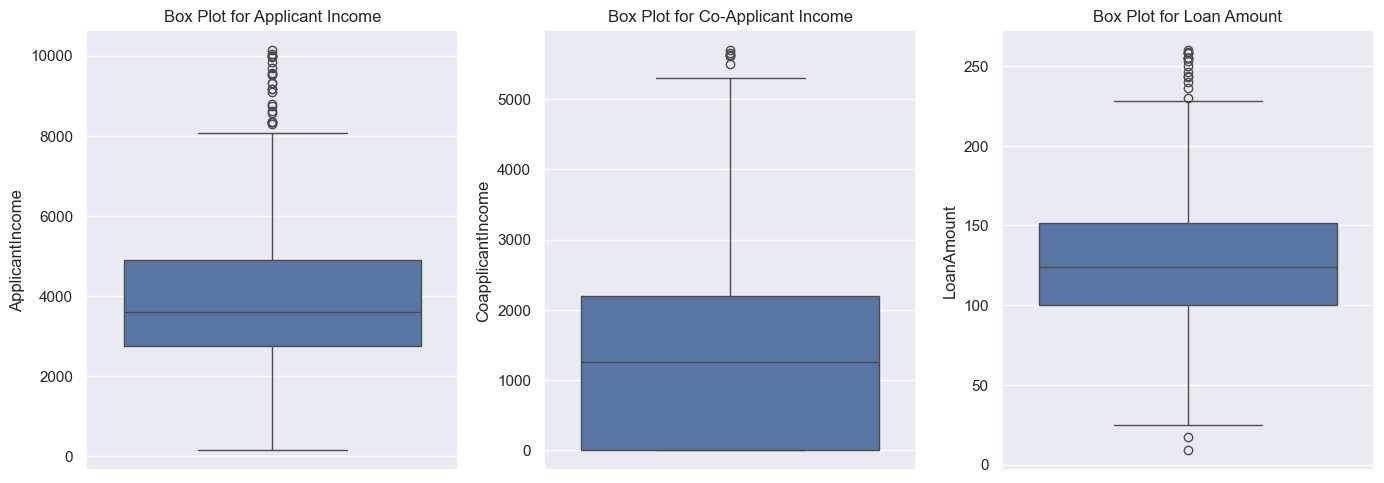

In [2005]:
# The data distribution after dealing without outliers - Box Plots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
# Starting with applicant income
sns.boxplot(data["ApplicantIncome"], ax=axes[0])
axes[0].set_title("Box Plot for Applicant Income")
# For coapplicant income
sns.boxplot(data["CoapplicantIncome"], ax=axes[1])
axes[1].set_title("Box Plot for Co-Applicant Income")
# For coapplicant income
sns.boxplot(data["LoanAmount"], ax=axes[2])
axes[2].set_title("Box Plot for Loan Amount")
plt.tight_layout()
plt.show()

# Question 3: Encoding, Scaling, and Feature Engineering

In [2006]:
# Creating new features for total income and loan amount per income
data["Total_Income"] = data["ApplicantIncome"] + data["CoapplicantIncome"]
data["Loan_Amount_Per_Income"] = data["LoanAmount"] / data["Total_Income"]
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Loan_Amount_Per_Income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y,5849.0,0.021884
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0.021015
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,0.022000
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,0.024287
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,0.023500


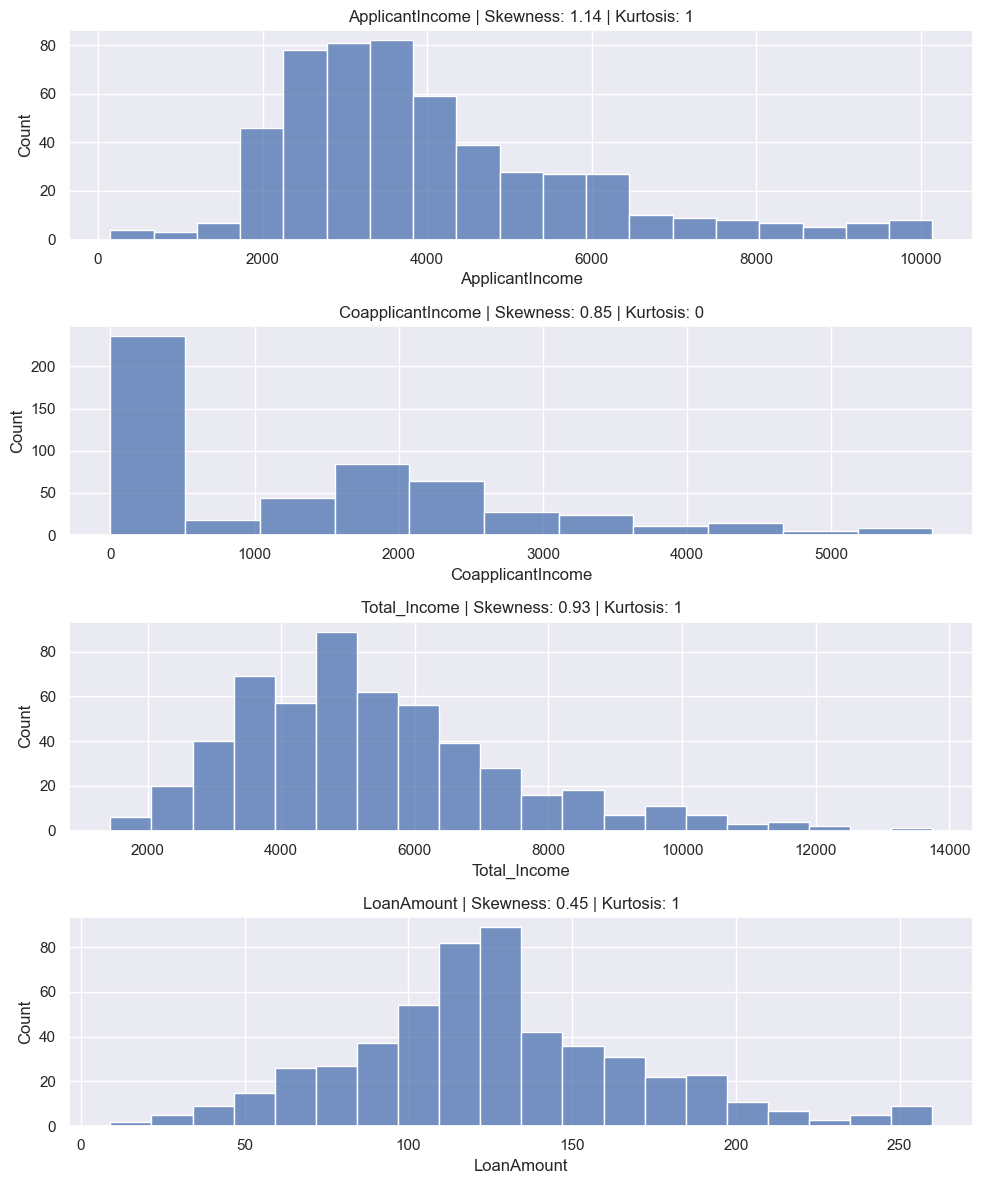

In [2007]:
# Calculating skewness and kurtosis for numerical columns - Before Transformation
sns.set_style("darkgrid")
numerical_columns = ["ApplicantIncome", "CoapplicantIncome", "Total_Income", "LoanAmount"]
plt.figure(figsize=(10, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, idx)
    sns.histplot(data[feature])
    plt.title(f"{feature} | Skewness: {round(data[feature].skew(), 2)} | Kurtosis: {round(data[feature].kurtosis())}")
plt.tight_layout()
plt.show()

In [2008]:
# Transforming the skewed features, loan amount and total income
# Using Log Transformation to reshape the skewed data
# This compresses large values and expands small values
# Adding 1 to prevent log(0) - MATH Error
data["Total_Income"] = np.log(data["Total_Income"] + 1)
data["LoanAmount"] = np.log(data["LoanAmount"] + 1)
data["ApplicantIncome"] = np.log(data["ApplicantIncome"] + 1)
data["CoapplicantIncome"] = np.log(data["CoapplicantIncome"] + 1)

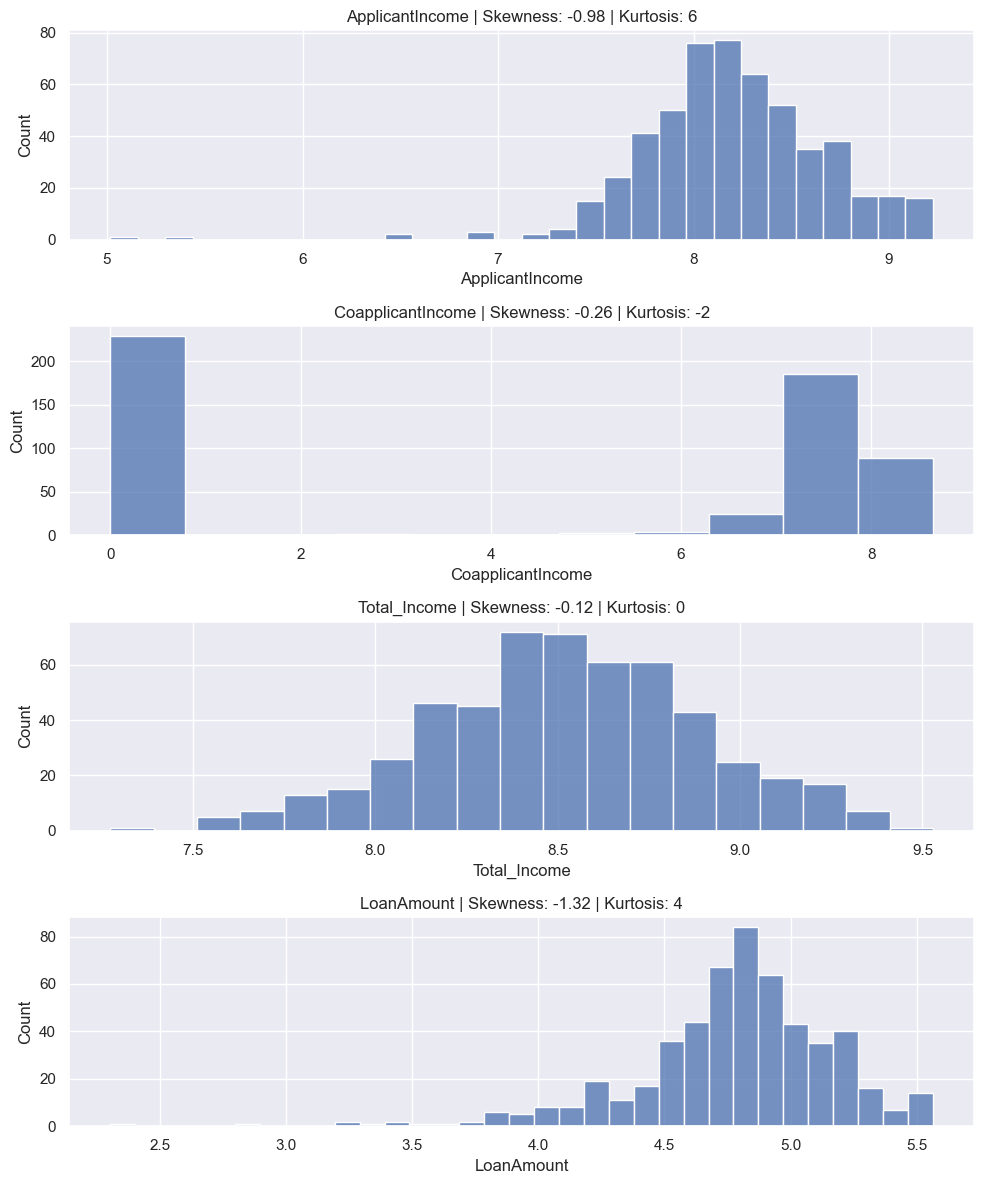

In [2009]:
# Calculating skewness and kurtosis for numerical columns - After Transformation
sns.set_style("darkgrid")
numerical_columns = ["ApplicantIncome", "CoapplicantIncome", "Total_Income", "LoanAmount"]
plt.figure(figsize=(10, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, idx)
    sns.histplot(data[feature])
    plt.title(f"{feature} | Skewness: {round(data[feature].skew(), 2)} | Kurtosis: {round(data[feature].kurtosis())}")
plt.tight_layout()
plt.show()

In [2010]:
# In order to determine the nature of encoding for categorical features
# We first determine categories for each column
categorical_columns = data.select_dtypes(include=["object"]).columns.tolist()
categorical_columns.remove("Loan_ID")
unique_values = {col: data[col].unique() for col in categorical_columns}
for column, values in unique_values.items():
    print(f"{column}: {values}")

Gender: ['Male' 'Female']
Married: ['No' 'Yes']
Dependents: ['0' '1' '3+' '2']
Education: ['Graduate' 'Not Graduate']
Self_Employed: ['No' 'Yes']
Property_Area: ['Urban' 'Rural' 'Semiurban']
Loan_Status: ['Y' 'N']


In [2011]:
# We can use label encoding for ordinal data and binary nominal data
# This applies for Gender, Married, Self_Employed, Education, Loan_Status
data["Gender"] = data["Gender"].map({"Male": 1, "Female": 0})
data["Married"] = data["Married"].map({"Yes": 1, "No": 0})
data["Self_Employed"] = data["Self_Employed"].map({"Yes": 1, "No": 0})
data["Education"] = data["Education"].map({"Graduate": 1, "Not Graduate": 0})
data["Loan_Status"] = data["Loan_Status"].map({"Y": 1, "N": 0})
# For Dependents, the order matters and thus we will use label encoding
# Since most of the values are integers, we will map 3+ to three
data["Dependents"] = data["Dependents"].replace("3+", 3).astype(float)


# For Property Area, since there are multiple labels with no order
# We will use onehot encoding
# We converted the data to three columns for Urban, Rural and Semiurban
# Each column is either 1 or 0 for the category the row lies on
data = pd.get_dummies(data, columns=["Property_Area"], dtype=int)
data.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Total_Income,Loan_Amount_Per_Income,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,1,0,0.0,1,0,8.674197,0.000000,4.859812,360.0,1.0,1,8.674197,0.021884,0,0,1
1,LP001003,1,1,1.0,1,0,8.430327,7.319202,4.859812,360.0,1.0,0,8.714732,0.021015,1,0,0
2,LP001005,1,1,0.0,1,1,8.006701,0.000000,4.204693,360.0,1.0,1,8.006701,0.022000,0,0,1
3,LP001006,1,1,0.0,0,0,7.857094,7.765993,4.795791,360.0,1.0,1,8.505525,0.024287,0,0,1
4,LP001008,1,0,0.0,1,0,8.699681,0.000000,4.955827,360.0,1.0,1,8.699681,0.023500,0,0,1


In [2012]:
# For scaling, we scale the continuous values and discrete numerical values
# Total_Income, LoanAmount, ApplicantIncome, CoapplicantIncome, Loan Amount Term
# Since the values have been transformed, we will use the StandardScaler,
# which assumes a normal distribution
scaler = StandardScaler()
data[["Total_Income", "CoapplicantIncome", "LoanAmount", "ApplicantIncome", "Loan_Amount_Term"]] = \
    scaler.fit_transform(data[["Total_Income", "CoapplicantIncome", "LoanAmount", "ApplicantIncome", "Loan_Amount_Term"]])

In [2013]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,535.0,8.130841e-01,0.390209,0.000000,1.000000,1.000000,1.000000,1.000000
Married,535.0,6.504673e-01,0.477269,0.000000,0.000000,1.000000,1.000000,1.000000
Dependents,535.0,7.177570e-01,0.994725,0.000000,0.000000,0.000000,1.000000,3.000000
Education,535.0,7.551402e-01,0.430406,0.000000,1.000000,1.000000,1.000000,1.000000
Self_Employed,535.0,1.140187e-01,0.318131,0.000000,0.000000,0.000000,0.000000,1.000000
ApplicantIncome,535.0,-3.386699e-16,1.000936,-6.734189,-0.601328,-0.035677,0.612695,2.152354
CoapplicantIncome,535.0,-7.968704e-17,1.000936,-1.148115,-1.148115,0.733775,0.879872,1.131498
LoanAmount,535.0,-1.804579e-15,1.000936,-6.153668,-0.402250,0.127975,0.622516,1.958967
Loan_Amount_Term,535.0,-3.087873e-16,1.000936,-5.055065,0.265785,0.265785,0.265785,2.100561
Credit_History,535.0,8.542056e-01,0.353230,0.000000,1.000000,1.000000,1.000000,1.000000


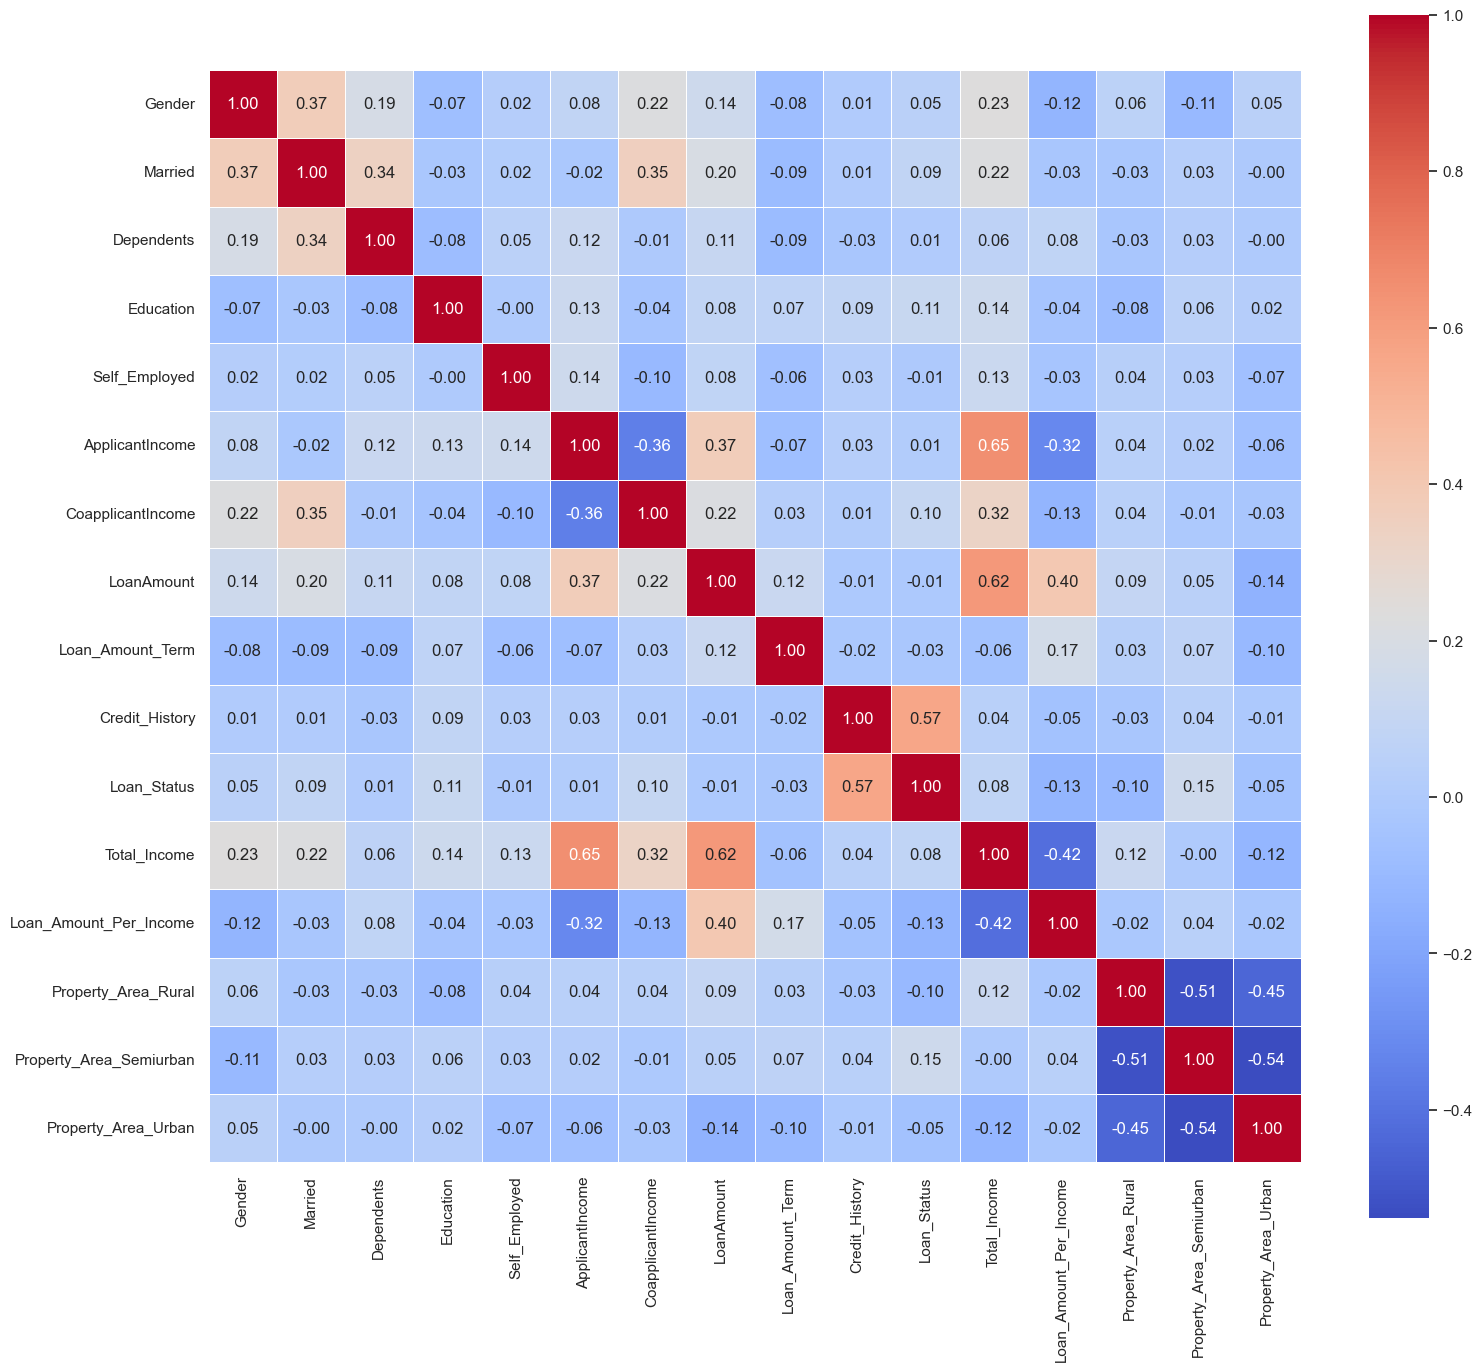

In [2014]:
# Plotting the Pearson Correlation Heatmap
# Helps determine multicollinearity
# Drop the Loan_ID
data = data.drop('Loan_ID', axis=1)
corr_matrix = data.corr(method='pearson') # Pearson correlation
plt.figure(figsize=(16, 14))
sns.set(style='whitegrid')
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            square=True, linewidths=0.5)
plt.title("")
plt.tight_layout()
plt.show()

In [2015]:
# Setting features and target columns
target = data["Loan_Status"]
feature_set = data.drop("Loan_Status", axis=1)

# Question 4: Model Building and Evaluation

In [2016]:
# Split the data set into train and test sets - 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    feature_set, target, test_size=0.3, random_state=42, stratify=target
)

# Train Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=12)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

# Train SGD Classifier
sgd_model = SGDClassifier(max_iter=1000, random_state=12)
sgd_model.fit(X_train, y_train)
sgd_preds = sgd_model.predict(X_test)

# Train SVM with Linear Kernel
svm_model = SVC(kernel='linear', random_state=12)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

# Evaluate
def get_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

# Compute metrics for each model
results = {
    'Logistic Regression': get_metrics(y_test, log_preds),
    'SGD Classifier': get_metrics(y_test, sgd_preds),
    'SVM (Linear Kernel)': get_metrics(y_test, svm_preds)
}

# Convert to a DataFrame for display
results_df = pd.DataFrame(results).T  # Transpose so models are rows
print(results_df)

                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.850932   0.838462  0.973214  0.900826
SGD Classifier       0.782609   0.829060  0.866071  0.847162
SVM (Linear Kernel)  0.863354   0.840909  0.991071  0.909836


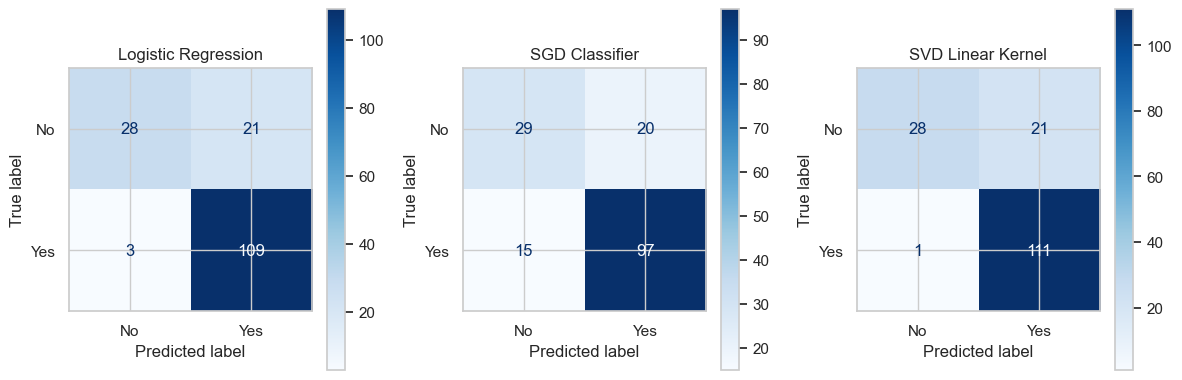

In [2017]:
# Confusion matrix
log_cm = confusion_matrix(y_test, log_preds)
sgd_cm = confusion_matrix(y_test, sgd_preds)
svm_cm = confusion_matrix(y_test, svm_preds)

# Plot the confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# First for logistic regression
fig = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=["No", "Yes"])
fig.plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Logistic Regression")

# For SGD Classifier
fig = ConfusionMatrixDisplay(confusion_matrix=sgd_cm, display_labels=["No", "Yes"])
fig.plot(ax=axes[1], cmap='Blues')
axes[1].set_title("SGD Classifier")

# For SGD Classifier
fig = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=["No", "Yes"])
fig.plot(ax=axes[2], cmap='Blues')
axes[2].set_title("SVD Linear Kernel")
plt.tight_layout()
plt.show()

# Question 5: Model Interpretability and Fairness

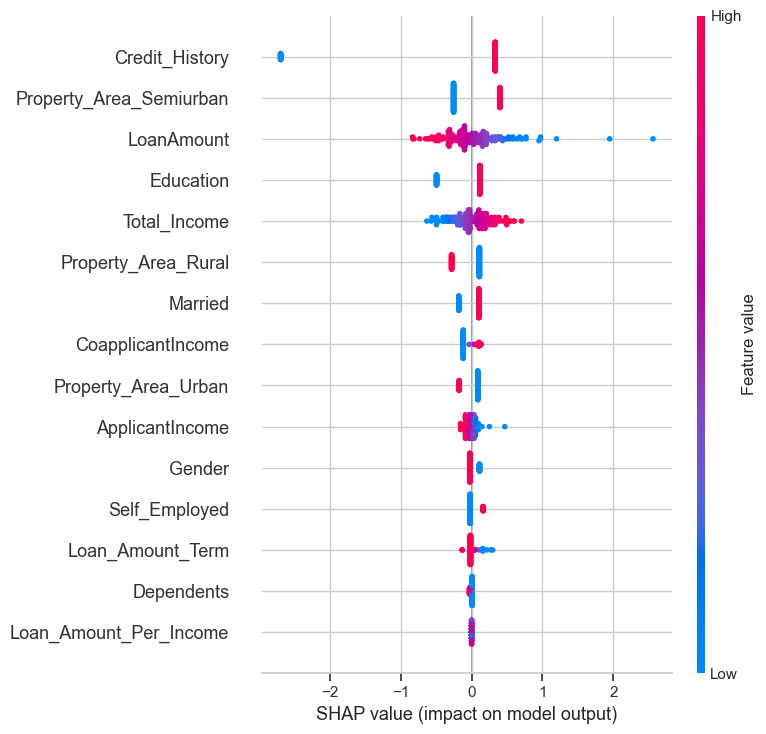

In [2018]:
# Comparing model interpretability - LIME vs SHAP - Post-hoc methods
# LIME and SHAP inform tells us about feature importance
explainer = shap.Explainer(log_model, X_train)
shap_value = explainer(X_test)
# Plotting a summary for the shap values
shap.summary_plot(shap_value, X_test)

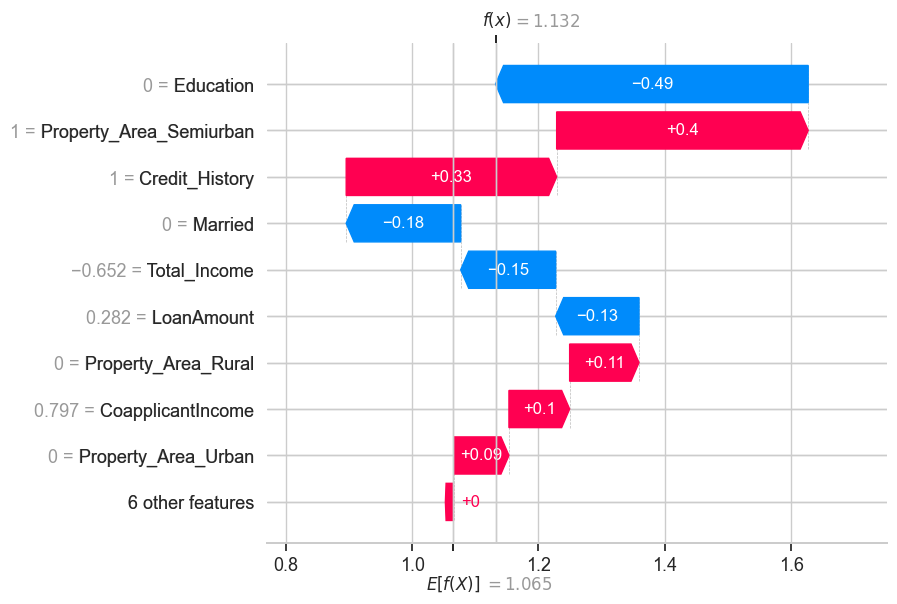

In [2021]:
shap.waterfall_plot(shap_value[0])